# Algoritmos Evolutivos & Aprendizado por Reforço

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Parte 1 - Algoritmos Evolutivos

Neste projeto, treinamos dois algoritmos diferentes para aprender a jogar o jogo Pacman ([código](https://gitlab.techniek.hva.nl/artificial-intelligence/pacman-contest-3)). Nesta primeira parte, treinamos um algoritmo evolutivo.

Como os fantasmas do jogo se comportam de forma aleatória, não é possível encontrar um caminho fixo para a vitória. Por isso, tentamos desenvolver um algoritmo que chegasse a uma estratégia ideal e não um caminho fixo. Para isso, nos inspiramos em Brandstetter & Ahmadi, 2012. Uma estratégia (implementada em [strategy.py](./strategy.py)) consiste em 5 árvores, onde as folhas consistem em valores calculados a partir do estado do jogo e os outros nós são operadores binários. Cada árvore está associada a uma das 4 direções e a ação a ser tomada é a que tiver maior valor dentre as ações possíveis no estado atual.

### Valores

Os valores (implementados em [values.py](./values.py)) possíveis para as folhas de uma árvore são:

- Coordenadas do Pacman
- Quantidade, Distância e Coordenadas do Fantasma não-comestível mais próximo
- Quantidade, Distância e Coordenadas do Fantasma comestível mais próximo
- Quantidade, Distância e Coordenadas da comida mais próxima
- Quantidade, Distância e Coordenadas da cápsula mais próxima
- Valores constantes: -1, 0, 0.1, 1, 10

### Operadores

Os operadores (implementados em [operators.py](./operators.py)) possíveis para os outros nós são:

- Subtração
- Adição
- Multiplicação
- Divisão (retorna 0 caso o divisor seja 0)
- Máximo
- Mínimo

### Geração Inicial

Para criar a primeira geração, implementamos em [strategyGenerator.py](./strategyGenerator.py) um mecanismo de geração de estratégia, onde a chance de um nó ser uma folha aumenta conforme sua profundidade, de forma a gerar árvores com tamanhos variados mas que tendam a não serem muito grandes. Cada geração possui 100 estratégias.

In [1]:
import strategyGenerator

def createGeneration(size=100):
    generation = []
    for _ in range(size):
        generation.append(strategyGenerator.generateStrategy())
    return generation

generation = createGeneration()

Para cada estratégia em uma geração, executamos 3 jogos de forma a levar em conta a aleatoriedade do movimento dos fantasmas. A medida de fitness de cada estratégia é a média dos scores obtidos nesses 3 jogos.

Ao final de cada execução, utilizamos o método da roleta para selecionar os membros que irão para a próxima geração, dos quais:

- 15% serão estratégias sobreviventes, simplesmente replicadas da geração anterior
- 15% serão estratégias com alguma mutação
- 70% serão estratégias resultantes da reprodução de duas estratégias da geração anterior, com crossover

Inicialmente, para o método da roleta, utilizamos a raiz quadrada da função fitness (com windowing para evitar raízes negativas). Porém, devido ao tempo gasto rodando cada geração, passamos a utilizar a função de fitness (ainda com windowing) diretamente para permitir uma convergência mais rápida.

### Mutação

As mutações possíveis, implementadas em [generationReproduction.py](./generationReproduction.py), são:

- A geração de uma nova árvore para substituir uma das 5 árvores da estratégia
- A troca de posição entre duas árvores já existentes
- A troca de ramos entre duas árvores já existentes

### Crossover

O crossover, também implementado em [generationReproduction.py](./generationReproduction.py), seleciona as árvores novas a partir de 3 estratégias:

- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução
- Selecionar uma das árvores dentre as duas estratégias selecionadas para reprodução e trocar um dos seus ramos pelo ramo da outa árvore
- Fundir as duas árvores anteriores em uma nova raiz comum selecionada aleatoriamente

Executamos, então, 5 gerações para cada layout do jogo, iniciando com smallClassic. O melhor método dentre essas gerações é retornado para ser utilizado no futuro.

In [2]:
import generationReproduction
import globalValues
import numpy as np
import pacman
import time
import copy

def selectByRoulette(gen, scores):
    probability = np.array(scores) - min(scores)
    probability = probability / np.sum(probability)
    return np.random.choice(gen, p=probability)

def runGeneticLearning(layout, generation, iterations=5):
    startTime = time.time()
    generationAverage = []
    generationMax = []
    generationMin = []
    winningStrategies = []

    for i in range(iterations):
        averageScore = []

        for strategy in generation:
            globalValues.strategy = strategy
            args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", "3", "-q"])
            games = pacman.runGames(**args)
            scores = [g.state.getScore() for g in games]
            averageScore.append(sum(scores)/len(scores))

        generationAverage.append(sum(averageScore)/len(averageScore))
        generationMax.append(max(averageScore))
        generationMin.append(min(averageScore))
        winningStrategies.append(copy.deepcopy(generation[averageScore.index(max(averageScore))]))

        if i < iterations - 1:
            newGeneration = []
            for _ in range(round(1.5 * len(generation) / 10)):
                newGeneration.append(selectByRoulette(generation, averageScore))
            for _ in range(round(1.5 * len(generation) / 10)):
                newGeneration.append(generationReproduction.mutate(selectByRoulette(generation, averageScore)))
            for _ in range(len(generation) - len(newGeneration)):
                firstStrategy = selectByRoulette(generation, averageScore)
                secondStrategy = selectByRoulette(generation, averageScore)
                newGeneration.append(generationReproduction.crossover(firstStrategy, secondStrategy))
    
    winningStrategy = winningStrategies[generationMax.index(max(generationMax))]
    print("Winning Strategy:", winningStrategy)
    print("Execution time: %s seconds" % (time.time() - startTime))
    return (generationAverage, generationMax, generationMin, winningStrategy)

generationAverage, generationMax, generationMin, smallClassicStrategy = runGeneticLearning("smallClassic", generation)

layout:  smallClassic
Pacman died! Score: -424
Pacman died! Score: -434
Pacman died! Score: -445
Average Score: -434.3333333333333
Scores:        -424.0, -434.0, -445.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -387
Pacman died! Score: -435
Pacman died! Score: -387
Average Score: -403.0
Scores:        -387.0, -435.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -426
Pacman died! Score: -428
Pacman died! Score: -424
Average Score: -426.0
Scores:        -426.0, -428.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -419
Pacman died! Score: -413
Pacman died! Score: -387
Average Score: -406.3333333333333
Scores:        -419.0, -413.0, -387.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -452
Pacman died! Score: -458
Average Score: -459

Pacman died! Score: -445
Pacman died! Score: -555
Pacman died! Score: -431
Average Score: -477.0
Scores:        -445.0, -555.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -453
Pacman died! Score: -383
Pacman died! Score: -400
Average Score: -412.0
Scores:        -453.0, -383.0, -400.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -440
Pacman died! Score: -421
Average Score: -437.0
Scores:        -450.0, -440.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -424
Pacman died! Score: -433
Pacman died! Score: -433
Average Score: -430.0
Scores:        -424.0, -433.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -393
Pacman died! Score: -490
Pacman died! Score: -419
Average Score: -434.0
Scores:        -393.0, -490.0, -419.0
Win R

Pacman died! Score: -439
Pacman died! Score: -411
Pacman died! Score: -425
Average Score: -425.0
Scores:        -439.0, -411.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -468
Pacman died! Score: -480
Pacman died! Score: -485
Average Score: -477.6666666666667
Scores:        -468.0, -480.0, -485.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -413
Pacman died! Score: -406
Pacman died! Score: -397
Average Score: -405.3333333333333
Scores:        -413.0, -406.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -426
Pacman died! Score: -414
Pacman died! Score: -430
Average Score: -423.3333333333333
Scores:        -426.0, -414.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -509
Pacman died! Score: -472
Average Score: -472.0
Scores:

Pacman died! Score: -467
Pacman died! Score: -522
Pacman died! Score: -454
Average Score: -481.0
Scores:        -467.0, -522.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -457
Pacman died! Score: -444
Pacman died! Score: -454
Average Score: -451.6666666666667
Scores:        -457.0, -444.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -427
Pacman died! Score: -421
Pacman died! Score: -455
Average Score: -434.3333333333333
Scores:        -427.0, -421.0, -455.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -389
Pacman died! Score: -464
Pacman died! Score: -520
Average Score: -457.6666666666667
Scores:        -389.0, -464.0, -520.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -466
Pacman died! Score: -413
Pacman died! Score: -437
Average Score: -438.666666666

Pacman died! Score: -439
Pacman died! Score: -497
Pacman died! Score: -470
Average Score: -468.6666666666667
Scores:        -439.0, -497.0, -470.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -444
Pacman died! Score: -415
Pacman died! Score: -454
Average Score: -437.6666666666667
Scores:        -444.0, -415.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -437
Pacman died! Score: -379
Pacman died! Score: -418
Average Score: -411.3333333333333
Scores:        -437.0, -379.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -396
Pacman died! Score: -431
Pacman died! Score: -389
Average Score: -405.3333333333333
Scores:        -396.0, -431.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -398
Pacman died! Score: -432
Pacman died! Score: -568
Average Score: -4

Pacman died! Score: -382
Pacman died! Score: -450
Pacman died! Score: -440
Average Score: -424.0
Scores:        -382.0, -450.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -484
Pacman died! Score: -431
Pacman died! Score: -460
Average Score: -458.3333333333333
Scores:        -484.0, -431.0, -460.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -402
Pacman died! Score: -425
Pacman died! Score: -382
Average Score: -403.0
Scores:        -402.0, -425.0, -382.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -450
Pacman died! Score: -477
Pacman died! Score: -424
Average Score: -450.3333333333333
Scores:        -450.0, -477.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -442
Pacman died! Score: -478
Pacman died! Score: -433
Average Score: -451.0
Scores:        -442

Pacman died! Score: -468
Pacman died! Score: -394
Pacman died! Score: -399
Average Score: -420.3333333333333
Scores:        -468.0, -394.0, -399.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -434
Pacman died! Score: -445
Pacman died! Score: -434
Average Score: -437.6666666666667
Scores:        -434.0, -445.0, -434.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -378
Pacman died! Score: -380
Pacman died! Score: -418
Average Score: -392.0
Scores:        -378.0, -380.0, -418.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -464
Pacman died! Score: -437
Pacman died! Score: -461
Average Score: -454.0
Scores:        -464.0, -437.0, -461.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -485
Pacman died! Score: -551
Pacman died! Score: -518
Average Score: -518.0
Scores:        -485

Pacman died! Score: -431
Pacman died! Score: -410
Pacman died! Score: -477
Average Score: -439.3333333333333
Scores:        -431.0, -410.0, -477.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -357
Pacman died! Score: -409
Pacman died! Score: -457
Average Score: -407.6666666666667
Scores:        -357.0, -409.0, -457.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -364
Pacman died! Score: -446
Pacman died! Score: -431
Average Score: -413.6666666666667
Scores:        -364.0, -446.0, -431.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -493
Pacman died! Score: -414
Pacman died! Score: -482
Average Score: -463.0
Scores:        -493.0, -414.0, -482.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -481
Pacman died! Score: -461
Pacman died! Score: -457
Average Score: -466.333333333

Pacman died! Score: -454
Pacman died! Score: -422
Average Score: -434.6666666666667
Scores:        -428.0, -454.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -420
Pacman died! Score: -479
Pacman died! Score: -405
Average Score: -434.6666666666667
Scores:        -420.0, -479.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -474
Pacman died! Score: -475
Pacman died! Score: -474
Average Score: -474.3333333333333
Scores:        -474.0, -475.0, -474.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -446
Pacman died! Score: -439
Pacman died! Score: -429
Average Score: -438.0
Scores:        -446.0, -439.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -396
Pacman died! Score: -449
Pacman died! Score: -445
Average Score: -430.0
Scores:        -396.0, -449.0, -

Pacman died! Score: -483
Pacman died! Score: -481
Pacman died! Score: -458
Average Score: -474.0
Scores:        -483.0, -481.0, -458.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -378
Pacman died! Score: -403
Pacman died! Score: -375
Average Score: -385.3333333333333
Scores:        -378.0, -403.0, -375.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -471
Pacman died! Score: -434
Pacman died! Score: -603
Average Score: -502.6666666666667
Scores:        -471.0, -434.0, -603.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -497
Pacman died! Score: -447
Pacman died! Score: -429
Average Score: -457.6666666666667
Scores:        -497.0, -447.0, -429.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -424
Pacman died! Score: -455
Pacman died! Score: -385
Average Score: -421.333333333

Pacman died! Score: -418
Pacman died! Score: -455
Pacman died! Score: -425
Average Score: -432.6666666666667
Scores:        -418.0, -455.0, -425.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -520
Pacman died! Score: -477
Pacman died! Score: -437
Average Score: -478.0
Scores:        -520.0, -477.0, -437.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -400
Pacman died! Score: -428
Pacman died! Score: -413
Average Score: -413.6666666666667
Scores:        -400.0, -428.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -395
Pacman died! Score: -387
Pacman died! Score: -428
Average Score: -403.3333333333333
Scores:        -395.0, -387.0, -428.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -399
Pacman died! Score: -410
Pacman died! Score: -416
Average Score: -408.333333333

Pacman died! Score: -429
Pacman died! Score: -467
Pacman died! Score: -430
Average Score: -442.0
Scores:        -429.0, -467.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -496
Pacman died! Score: -480
Pacman died! Score: -461
Average Score: -479.0
Scores:        -496.0, -480.0, -461.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -435
Pacman died! Score: -507
Pacman died! Score: -421
Average Score: -454.3333333333333
Scores:        -435.0, -507.0, -421.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -424
Pacman died! Score: -467
Pacman died! Score: -454
Average Score: -448.3333333333333
Scores:        -424.0, -467.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -459
Pacman died! Score: -474
Pacman died! Score: -472
Average Score: -468.3333333333333
Scores:

Pacman died! Score: -438
Pacman died! Score: -449
Pacman died! Score: -451
Average Score: -446.0
Scores:        -438.0, -449.0, -451.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -479
Pacman died! Score: -478
Pacman died! Score: -472
Average Score: -476.3333333333333
Scores:        -479.0, -478.0, -472.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -403
Pacman died! Score: -427
Pacman died! Score: -397
Average Score: -409.0
Scores:        -403.0, -427.0, -397.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -510
Pacman died! Score: -421
Pacman died! Score: -471
Average Score: -467.3333333333333
Scores:        -510.0, -421.0, -471.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -431
Pacman died! Score: -623
Pacman died! Score: -429
Average Score: -494.3333333333333
Scores:

Pacman died! Score: -447
Pacman died! Score: -478
Average Score: -464.0
Scores:        -467.0, -447.0, -478.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -567
Pacman died! Score: -644
Pacman died! Score: -514
Average Score: -575.0
Scores:        -567.0, -644.0, -514.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -397
Pacman died! Score: -391
Pacman died! Score: -449
Average Score: -412.3333333333333
Scores:        -397.0, -391.0, -449.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -406
Pacman died! Score: -388
Pacman died! Score: -412
Average Score: -402.0
Scores:        -406.0, -388.0, -412.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  smallClassic
Pacman died! Score: -438
Pacman died! Score: -438
Pacman died! Score: -450
Average Score: -442.0
Scores:        -438.0, -438.0, -450.0
Win Rate:      0/3

Podemos observar a progressão do treinamento através do gráfico abaixo:

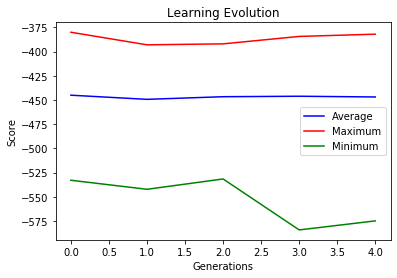

In [3]:
import matplotlib.pyplot as plt

def plotLearningEvolution(generationAverage, generationMax, generationMin):
    generationAverage = np.array(generationAverage)
    generationMax = np.array(generationMax)
    generationMin = np.array(generationMin)

    G = list(range(generationAverage.size))
    plt.title("Learning Evolution")
    plt.xlabel("Generations")
    plt.ylabel("Score")
    plt.plot(G, generationAverage, color='blue', label='Average')
    plt.plot(G, generationMax, color='red', label='Maximum')
    plt.plot(G, generationMin, color='green', label='Minimum')
    plt.legend()
    plt.show()

plotLearningEvolution(generationAverage, generationMax, generationMin)

Agora, vamos executar 5 gerações para o layout mediumClassic:

In [4]:
generation = createGeneration()
generationAverage, generationMax, generationMin, mediumClassicStrategy = runGeneticLearning("mediumClassic", generation)

layout:  mediumClassic
Pacman died! Score: -474
Pacman died! Score: -490
Pacman died! Score: -636
Average Score: -533.3333333333334
Scores:        -474.0, -490.0, -636.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -486
Pacman died! Score: -482
Pacman died! Score: -520
Average Score: -496.0
Scores:        -486.0, -482.0, -520.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -508
Pacman died! Score: -501
Pacman died! Score: -527
Average Score: -512.0
Scores:        -508.0, -501.0, -527.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -539
Pacman died! Score: -544
Pacman died! Score: -497
Average Score: -526.6666666666666
Scores:        -539.0, -544.0, -497.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -503
Pacman died! Score: -485
Pacman died! Score: -507
Average Score:

Pacman died! Score: -474
Pacman died! Score: -488
Pacman died! Score: -630
Average Score: -530.6666666666666
Scores:        -474.0, -488.0, -630.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -591
Pacman died! Score: -545
Pacman died! Score: -487
Average Score: -541.0
Scores:        -591.0, -545.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -322
Pacman died! Score: -402
Pacman died! Score: -496
Average Score: -406.6666666666667
Scores:        -322.0, -402.0, -496.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -361
Pacman died! Score: -439
Pacman died! Score: -499
Average Score: -433.0
Scores:        -361.0, -439.0, -499.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -136
Pacman died! Score: -410
Pacman died! Score: -368
Average Score: -304.6666666666667
Sco

Pacman died! Score: -589
Pacman died! Score: -487
Pacman died! Score: -484
Average Score: -520.0
Scores:        -589.0, -487.0, -484.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -399
Pacman died! Score: -420
Pacman died! Score: -584
Average Score: -467.6666666666667
Scores:        -399.0, -420.0, -584.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -625
Pacman died! Score: -472
Average Score: -530.0
Scores:        -493.0, -625.0, -472.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -353
Pacman died! Score: -370
Pacman died! Score: -377
Average Score: -366.6666666666667
Scores:        -353.0, -370.0, -377.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -441
Pacman died! Score: -439
Pacman died! Score: -470
Average Score: -450.0
Scores:        

Pacman died! Score: -557
Pacman died! Score: -507
Pacman died! Score: -529
Average Score: -531.0
Scores:        -557.0, -507.0, -529.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -368
Pacman died! Score: -387
Pacman died! Score: -362
Average Score: -372.3333333333333
Scores:        -368.0, -387.0, -362.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -393
Pacman died! Score: -438
Pacman died! Score: -342
Average Score: -391.0
Scores:        -393.0, -438.0, -342.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -515
Pacman died! Score: -488
Pacman died! Score: -500
Average Score: -501.0
Scores:        -515.0, -488.0, -500.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -438
Pacman died! Score: -449
Pacman died! Score: -439
Average Score: -442.0
Scores:        -438.0, -449

Pacman died! Score: -434
Pacman died! Score: -415
Pacman died! Score: -520
Average Score: -456.3333333333333
Scores:        -434.0, -415.0, -520.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -394
Pacman died! Score: -323
Pacman died! Score: -473
Average Score: -396.6666666666667
Scores:        -394.0, -323.0, -473.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -396
Pacman died! Score: -421
Pacman died! Score: -398
Average Score: -405.0
Scores:        -396.0, -421.0, -398.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -551
Pacman died! Score: -531
Pacman died! Score: -499
Average Score: -527.0
Scores:        -551.0, -531.0, -499.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -440
Pacman died! Score: -192
Pacman died! Score: -448
Average Score: -360.0
Scores:        

Pacman died! Score: -586
Pacman died! Score: -500
Pacman died! Score: -543
Average Score: -543.0
Scores:        -586.0, -500.0, -543.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -356
Pacman died! Score: -365
Pacman died! Score: -401
Average Score: -374.0
Scores:        -356.0, -365.0, -401.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -457
Pacman died! Score: -434
Pacman died! Score: -439
Average Score: -443.3333333333333
Scores:        -457.0, -434.0, -439.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -493
Pacman died! Score: -491
Pacman died! Score: -511
Average Score: -498.3333333333333
Scores:        -493.0, -491.0, -511.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -496
Pacman died! Score: -527
Pacman died! Score: -566
Average Score: -529.6666666666666
Sco

Pacman died! Score: -552
Pacman died! Score: -518
Pacman died! Score: -503
Average Score: -524.3333333333334
Scores:        -552.0, -518.0, -503.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -537
Pacman died! Score: -504
Pacman died! Score: -601
Average Score: -547.3333333333334
Scores:        -537.0, -504.0, -601.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -473
Pacman died! Score: -481
Pacman died! Score: -487
Average Score: -480.3333333333333
Scores:        -473.0, -481.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -544
Pacman died! Score: -585
Pacman died! Score: -492
Average Score: -540.3333333333334
Scores:        -544.0, -585.0, -492.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -299
Pacman died! Score: -449
Pacman died! Score: -381
Average Score

Pacman died! Score: -400
Pacman died! Score: -377
Pacman died! Score: -380
Average Score: -385.6666666666667
Scores:        -400.0, -377.0, -380.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -479
Pacman died! Score: -526
Pacman died! Score: -483
Average Score: -496.0
Scores:        -479.0, -526.0, -483.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -520
Pacman died! Score: -770
Pacman died! Score: -515
Average Score: -601.6666666666666
Scores:        -520.0, -770.0, -515.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -468
Pacman died! Score: -496
Pacman died! Score: -474
Average Score: -479.3333333333333
Scores:        -468.0, -496.0, -474.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -524
Pacman died! Score: -498
Pacman died! Score: -519
Average Score: -513.66666

Pacman died! Score: -577
Pacman died! Score: -590
Pacman died! Score: -515
Average Score: -560.6666666666666
Scores:        -577.0, -590.0, -515.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -627
Pacman died! Score: -688
Pacman died! Score: -527
Average Score: -614.0
Scores:        -627.0, -688.0, -527.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -509
Pacman died! Score: -590
Pacman died! Score: -512
Average Score: -537.0
Scores:        -509.0, -590.0, -512.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -394
Pacman died! Score: -498
Pacman died! Score: -342
Average Score: -411.3333333333333
Scores:        -394.0, -498.0, -342.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -487
Pacman died! Score: -507
Pacman died! Score: -486
Average Score: -493.3333333333333
Sco

Pacman died! Score: -528
Pacman died! Score: -486
Pacman died! Score: -554
Average Score: -522.6666666666666
Scores:        -528.0, -486.0, -554.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -544
Pacman died! Score: -576
Pacman died! Score: -632
Average Score: -584.0
Scores:        -544.0, -576.0, -632.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -384
Pacman died! Score: -410
Pacman died! Score: -334
Average Score: -376.0
Scores:        -384.0, -410.0, -334.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -383
Pacman died! Score: -57
Pacman died! Score: -430
Average Score: -290.0
Scores:        -383.0, -57.0, -430.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -460
Pacman died! Score: -464
Pacman died! Score: -488
Average Score: -470.6666666666667
Scores:        -4

Pacman died! Score: -501
Pacman died! Score: -597
Pacman died! Score: -590
Average Score: -562.6666666666666
Scores:        -501.0, -597.0, -590.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -504
Pacman died! Score: -386
Pacman died! Score: -389
Average Score: -426.3333333333333
Scores:        -504.0, -386.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -531
Pacman died! Score: -479
Pacman died! Score: -511
Average Score: -507.0
Scores:        -531.0, -479.0, -511.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -482
Pacman died! Score: -505
Pacman died! Score: -493
Average Score: -493.3333333333333
Scores:        -482.0, -505.0, -493.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -506
Pacman died! Score: -578
Pacman died! Score: -507
Average Score: -530.33333

Pacman died! Score: -745
Pacman died! Score: -546
Pacman died! Score: -519
Average Score: -603.3333333333334
Scores:        -745.0, -546.0, -519.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -154
Pacman died! Score: -170
Pacman died! Score: -404
Average Score: -242.66666666666666
Scores:        -154.0, -170.0, -404.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -466
Pacman died! Score: -520
Pacman died! Score: -554
Average Score: -513.3333333333334
Scores:        -466.0, -520.0, -554.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -388
Pacman died! Score: -397
Pacman died! Score: -396
Average Score: -393.6666666666667
Scores:        -388.0, -397.0, -396.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -525
Pacman died! Score: -508
Pacman died! Score: -547
Average Scor

Pacman died! Score: -505
Pacman died! Score: -187
Pacman died! Score: -487
Average Score: -393.0
Scores:        -505.0, -187.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -500
Pacman died! Score: -503
Pacman died! Score: -494
Average Score: -499.0
Scores:        -500.0, -503.0, -494.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -594
Pacman died! Score: -452
Pacman died! Score: -500
Average Score: -515.3333333333334
Scores:        -594.0, -452.0, -500.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -435
Pacman died! Score: -405
Pacman died! Score: -410
Average Score: -416.6666666666667
Scores:        -435.0, -405.0, -410.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -456
Pacman died! Score: -412
Pacman died! Score: -449
Average Score: -439.0
Scores:        

Pacman died! Score: -395
Pacman died! Score: -398
Average Score: -407.0
Scores:        -428.0, -395.0, -398.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -428
Pacman died! Score: -484
Pacman died! Score: -426
Average Score: -446.0
Scores:        -428.0, -484.0, -426.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -498
Pacman died! Score: -556
Average Score: -513.0
Scores:        -485.0, -498.0, -556.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -485
Pacman died! Score: -493
Pacman died! Score: -496
Average Score: -491.3333333333333
Scores:        -485.0, -493.0, -496.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  mediumClassic
Pacman died! Score: -607
Pacman died! Score: -503
Pacman died! Score: -506
Average Score: -538.6666666666666
Scores:        -607.0, -503.0, -506.0
Wi

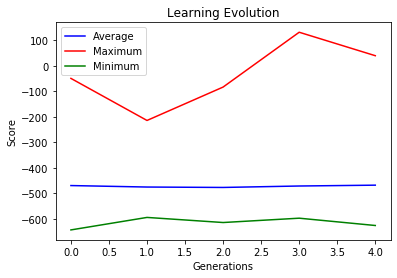

In [5]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

Por último, executamos 5 gerações para o layout originalClassic:

In [6]:
generation = createGeneration()
generationAverage, generationMax, generationMin, originalClassicStrategy = runGeneticLearning("originalClassic", generation)

layout:  originalClassic
Pacman died! Score: -445
Pacman died! Score: -383
Pacman died! Score: -541
Average Score: -456.3333333333333
Scores:        -445.0, -383.0, -541.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -248
Pacman died! Score: -212
Pacman died! Score: -228
Average Score: -229.33333333333334
Scores:        -248.0, -212.0, -228.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -218
Pacman died! Score: -215
Pacman died! Score: -329
Average Score: -254.0
Scores:        -218.0, -215.0, -329.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -653
Pacman died! Score: -622
Pacman died! Score: -606
Average Score: -627.0
Scores:        -653.0, -622.0, -606.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -204
Pacman died! Score: -362
Pacman died! Score: -164
Ave

Pacman died! Score: -403
Pacman died! Score: -694
Pacman died! Score: -517
Average Score: -538.0
Scores:        -403.0, -694.0, -517.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -453
Pacman died! Score: -446
Pacman died! Score: -422
Average Score: -440.3333333333333
Scores:        -453.0, -446.0, -422.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -403
Pacman died! Score: -415
Pacman died! Score: -534
Average Score: -450.6666666666667
Scores:        -403.0, -415.0, -534.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -1029
Pacman died! Score: -557
Pacman died! Score: -655
Average Score: -747.0
Scores:        -1029.0, -557.0, -655.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -697
Pacman died! Score: -390
Pacman died! Score: -497
Average Score: -528.0
Score

Pacman died! Score: -797
Pacman died! Score: -495
Pacman died! Score: -424
Average Score: -572.0
Scores:        -797.0, -495.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -390
Pacman died! Score: -356
Pacman died! Score: -339
Average Score: -361.6666666666667
Scores:        -390.0, -356.0, -339.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -530
Pacman died! Score: -572
Pacman died! Score: -502
Average Score: -534.6666666666666
Scores:        -530.0, -572.0, -502.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -312
Pacman died! Score: -502
Pacman died! Score: -458
Average Score: -424.0
Scores:        -312.0, -502.0, -458.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -483
Pacman died! Score: -618
Pacman died! Score: -975
Average Score: -692.0
Scores:

Pacman died! Score: -486
Pacman died! Score: -482
Pacman died! Score: -555
Average Score: -507.6666666666667
Scores:        -486.0, -482.0, -555.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -465
Pacman died! Score: -442
Pacman died! Score: -424
Average Score: -443.6666666666667
Scores:        -465.0, -442.0, -424.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -624
Pacman died! Score: -642
Pacman died! Score: -703
Average Score: -656.3333333333334
Scores:        -624.0, -642.0, -703.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -490
Pacman died! Score: -472
Pacman died! Score: -458
Average Score: -473.3333333333333
Scores:        -490.0, -472.0, -458.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -533
Pacman died! Score: -427
Pacman died! Score: -403
Avera

Pacman died! Score: -416
Pacman died! Score: -481
Pacman died! Score: -597
Average Score: -498.0
Scores:        -416.0, -481.0, -597.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -416
Pacman died! Score: -497
Pacman died! Score: -440
Average Score: -451.0
Scores:        -416.0, -497.0, -440.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -523
Pacman died! Score: -552
Pacman died! Score: -434
Average Score: -503.0
Scores:        -523.0, -552.0, -434.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -663
Pacman died! Score: -417
Pacman died! Score: -655
Average Score: -578.3333333333334
Scores:        -663.0, -417.0, -655.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -413
Pacman died! Score: -470
Pacman died! Score: -412
Average Score: -431.6666666666667
Scores:

Pacman died! Score: -433
Pacman died! Score: -486
Pacman died! Score: -493
Average Score: -470.6666666666667
Scores:        -433.0, -486.0, -493.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -419
Pacman died! Score: -503
Pacman died! Score: -432
Average Score: -451.3333333333333
Scores:        -419.0, -503.0, -432.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -224
Pacman died! Score: -172
Pacman died! Score: -275
Average Score: -223.66666666666666
Scores:        -224.0, -172.0, -275.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -474
Pacman died! Score: -433
Pacman died! Score: -443
Average Score: -450.0
Scores:        -474.0, -433.0, -443.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -486
Pacman died! Score: -406
Pacman died! Score: -515
Average Score: -

Pacman died! Score: -382
Pacman died! Score: -425
Pacman died! Score: -544
Average Score: -450.3333333333333
Scores:        -382.0, -425.0, -544.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -456
Pacman died! Score: -384
Pacman died! Score: -487
Average Score: -442.3333333333333
Scores:        -456.0, -384.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -620
Pacman died! Score: -428
Pacman died! Score: -405
Average Score: -484.3333333333333
Scores:        -620.0, -428.0, -405.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -420
Pacman died! Score: -544
Pacman died! Score: -481
Average Score: -481.6666666666667
Scores:        -420.0, -544.0, -481.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -425
Pacman died! Score: -429
Pacman died! Score: -482
Avera

Pacman died! Score: -462
Pacman died! Score: -388
Pacman died! Score: -506
Average Score: -452.0
Scores:        -462.0, -388.0, -506.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -421
Pacman died! Score: -356
Pacman died! Score: -389
Average Score: -388.6666666666667
Scores:        -421.0, -356.0, -389.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -473
Pacman died! Score: -811
Pacman died! Score: -555
Average Score: -613.0
Scores:        -473.0, -811.0, -555.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -261
Pacman died! Score: -184
Pacman died! Score: 9
Average Score: -145.33333333333334
Scores:        -261.0, -184.0, 9.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -444
Pacman died! Score: -484
Pacman died! Score: -716
Average Score: -548.0
Scores:     

Pacman died! Score: -487
Pacman died! Score: -455
Pacman died! Score: -699
Average Score: -547.0
Scores:        -487.0, -455.0, -699.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -450
Pacman died! Score: -473
Pacman died! Score: -417
Average Score: -446.6666666666667
Scores:        -450.0, -473.0, -417.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -441
Pacman died! Score: -461
Pacman died! Score: -612
Average Score: -504.6666666666667
Scores:        -441.0, -461.0, -612.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -611
Pacman died! Score: -529
Pacman died! Score: -547
Average Score: -562.3333333333334
Scores:        -611.0, -529.0, -547.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -412
Pacman died! Score: -541
Pacman died! Score: -508
Average Score: -4

Pacman died! Score: -532
Pacman died! Score: -412
Pacman died! Score: -553
Average Score: -499.0
Scores:        -532.0, -412.0, -553.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -514
Pacman died! Score: -539
Pacman died! Score: -463
Average Score: -505.3333333333333
Scores:        -514.0, -539.0, -463.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -197
Pacman died! Score: -305
Pacman died! Score: -248
Average Score: -250.0
Scores:        -197.0, -305.0, -248.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -481
Pacman died! Score: -437
Pacman died! Score: -503
Average Score: -473.6666666666667
Scores:        -481.0, -437.0, -503.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -536
Pacman died! Score: -506
Pacman died! Score: -470
Average Score: -504.0
Scores:

Pacman died! Score: -811
Pacman died! Score: -436
Pacman died! Score: -487
Average Score: -578.0
Scores:        -811.0, -436.0, -487.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -546
Pacman died! Score: -458
Pacman died! Score: -575
Average Score: -526.3333333333334
Scores:        -546.0, -458.0, -575.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -474
Pacman died! Score: -557
Pacman died! Score: -551
Average Score: -527.3333333333334
Scores:        -474.0, -557.0, -551.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -275
Pacman died! Score: -221
Pacman died! Score: -218
Average Score: -238.0
Scores:        -275.0, -221.0, -218.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -468
Pacman died! Score: -515
Pacman died! Score: -706
Average Score: -563.0
Scores:

Pacman died! Score: -539
Pacman died! Score: -720
Pacman died! Score: -446
Average Score: -568.3333333333334
Scores:        -539.0, -720.0, -446.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -524
Pacman died! Score: -493
Pacman died! Score: -413
Average Score: -476.6666666666667
Scores:        -524.0, -493.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -622
Pacman died! Score: -474
Pacman died! Score: -413
Average Score: -503.0
Scores:        -622.0, -474.0, -413.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -381
Pacman died! Score: -381
Pacman died! Score: -433
Average Score: -398.3333333333333
Scores:        -381.0, -381.0, -433.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -616
Pacman died! Score: -519
Pacman died! Score: -519
Average Score: -5

Pacman died! Score: -561
Pacman died! Score: -675
Pacman died! Score: -550
Average Score: -595.3333333333334
Scores:        -561.0, -675.0, -550.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -510
Pacman died! Score: -517
Pacman died! Score: -454
Average Score: -493.6666666666667
Scores:        -510.0, -517.0, -454.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -595
Pacman died! Score: -1369
Pacman died! Score: -561
Average Score: -841.6666666666666
Scores:        -595.0, -1369.0, -561.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -570
Pacman died! Score: -385
Pacman died! Score: -442
Average Score: -465.6666666666667
Scores:        -570.0, -385.0, -442.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -420
Pacman died! Score: -592
Pacman died! Score: -397
Ave

Pacman died! Score: -221
Pacman died! Score: -182
Pacman died! Score: -290
Average Score: -231.0
Scores:        -221.0, -182.0, -290.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -431
Pacman died! Score: -523
Pacman died! Score: -447
Average Score: -467.0
Scores:        -431.0, -523.0, -447.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -533
Pacman died! Score: -527
Pacman died! Score: -583
Average Score: -547.6666666666666
Scores:        -533.0, -527.0, -583.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -293
Pacman died! Score: -248
Pacman died! Score: -266
Average Score: -269.0
Scores:        -293.0, -248.0, -266.0
Win Rate:      0/3 (0.00)
Record:        Loss, Loss, Loss
layout:  originalClassic
Pacman died! Score: -482
Pacman died! Score: -436
Pacman died! Score: -471
Average Score: -463.0
Scores:        -482

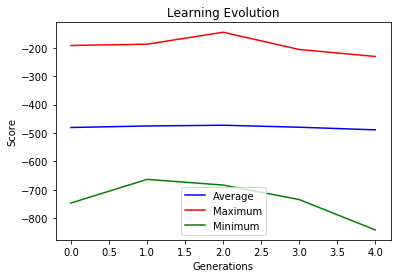

In [7]:
plotLearningEvolution(generationAverage, generationMax, generationMin)